# ReCovNet: Deep Reinforcement Learning for Solving MBCLP

## Prepare: Install dependencies

* python=3.7
* PyTorch>=1.1
* numpy

In [1]:
import os
import sys
sys.path.append('..')
import numpy as np
import random
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from utils import torch_load_cpu, load_problem, get_inner_model, move_to
from nets.attention_model import AttentionModel
from train import train_epoch, validate

from IPython.display import display, HTML
# Set max-height to 'none' to prevent scrollbar
display(HTML("<style>.output_scroll { height: auto !important; }</style>"))

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Load the settings

In [2]:
# load the run args
%run "../options"

# Set the random seed
torch.manual_seed(2024)

# Set the device
use_cuda=True
opts.device = torch.device("cuda" if use_cuda else "cpu")
opts

problem = load_problem(opts.problem)
problem

problems.MCLP.problem_MCLP.MCLP

## Initialize our policy network

In [3]:
model_class = {
    # 'pointer': PointerNetwork,
    'attention': AttentionModel
}.get(opts.model, None)

assert model_class is not None, "Unknown model: {}".format(model_class)
model = model_class(
    opts.embedding_dim,
    opts.hidden_dim,
    problem,
    n_encode_layers=opts.n_encode_layers,
    mask_inner=True,
    mask_logits=True,
    normalization=opts.normalization,
    tanh_clipping=opts.tanh_clipping,
    checkpoint_encoder=opts.checkpoint_encoder,
    shrink_size=opts.shrink_size,
    dy=False
).to(opts.device)

model

AttentionModel(
  (init_embed): Linear(in_features=2, out_features=128, bias=True)
  (init_dynamic): Linear(in_features=1, out_features=32, bias=True)
  (l2_dynamic): Linear(in_features=32, out_features=64, bias=True)
  (l3_dynamic): Linear(in_features=64, out_features=128, bias=True)
  (embedder): GraphAttentionEncoder(
    (layers): Sequential(
      (0): MultiHeadAttentionLayer(
        (0): SkipConnection(
          (module): MultiHeadAttention()
        )
        (1): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): SkipConnection(
          (module): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
          )
        )
        (3): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
  

## Helper methods

In [11]:
def plot_points(demand_points, demand_vals, candidate_points, selected_idxes, radius, title=None):
    """
    Plot the demand points, candidate points (CLS), and selected coverage circles.

    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param selected_idxes: List of indexes corresponding to the selected candidate points
    :param radius: Radius for the coverage circles
    :param demand_vals: Array of demand values corresponding to each demand point
    """
    if len(demand_points) != len(demand_vals):
        raise ValueError("The length of demand_points and demand_vals must be the same.")

    plt.figure(figsize=(10, 8))

    # Normalize demand values for color mapping
    norm = plt.Normalize(vmin=min(demand_vals), vmax=max(demand_vals))
    cmap = plt.cm.Blues

    # Plot demand points with color intensity based on demand values
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c=demand_vals, cmap=cmap, norm=norm, label='Demand Points', s=10)

    # Plot candidate points
    plt.scatter(candidate_points[:, 0], candidate_points[:, 1], c='red', label='Candidate Points (CLS)', s=30, marker='x')

    # Plot selected points and their coverage circles
    for idx in selected_idxes:
        point = candidate_points[idx]
        circle = plt.Circle((point[0], point[1]), radius, color='green', fill=False, linestyle='--',
                            label='Coverage Area' if idx == selected_idxes[0] else "")
        plt.gca().add_patch(circle)
        plt.scatter(point[0], point[1], c='green', label='Selected Points' if idx == selected_idxes[0] else "",
                    s=30, marker='o')

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    if title:
        plt.title(title)
    else:
        plt.title(
            f"{len(demand_points)} demand units - {len(candidate_points)} CLS - {len(selected_idxes)} selected (r={radius})"
        )
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')
    plt.show()
    
    
def calculate_solution_objective(demand_points, demand_vals, facility_candidate_locations, radius, selected_facility_indexes):
    covered_points = set()  

    for facility_idx in selected_facility_indexes:
        facility = facility_candidate_locations[facility_idx]  

        for i, demand_point in enumerate(demand_points):
            distance = np.linalg.norm(facility - demand_point)  
            if distance <= radius:
                covered_points.add(i)  

    total_demand_covered = sum(demand_vals[i] for i in covered_points)
    # Print the number of covered points
    print(f"Number of covered demand points: {len(covered_points)}")
    print(f"The objective value: {total_demand_covered}")
    
    
    return total_demand_covered
    

def gen_random_data(num_sample):
    random_datasets = []
    for i in range(num_sample):
        random_data = {}
        random_data["users"] = torch.tensor(users).to(torch.float32)
        random_data["facilities"] = torch.tensor(np.array(facilities)).to(torch.float32)
        random_data['demand'] = torch.tensor(demand).to(torch.float32)
        random_data["p"] = n_centers
        random_data["r"] = 0.1
        random_datasets.append(random_data)
    return random_datasets


def get_best(sequences, cost, ids=None, batch_size=None):
    """
    Ids contains [0, 0, 0, 1, 1, 2, ..., n, n, n] if 3 solutions found for 0th instance, 2 for 1st, etc
    :param sequences:
    :param lengths:
    :param ids:
    :return: list with n sequences and list with n lengths of solutions
    """
    if ids is None:
        idx = cost.argmin()
        return sequences[idx:idx+1, ...], cost[idx:idx+1, ...]

    splits = np.hstack([0, np.where(ids[:-1] != ids[1:])[0] + 1])
    mincosts = np.minimum.reduceat(cost, splits)

    group_lengths = np.diff(np.hstack([splits, len(ids)]))
    all_argmin = np.flatnonzero(np.repeat(mincosts, group_lengths) == cost)
    result = np.full(len(group_lengths) if batch_size is None else batch_size, -1, dtype=int)

    result[ids[all_argmin[::-1]]] = all_argmin[::-1]

    return [sequences[i] if i >= 0 else None for i in result], [cost[i] if i >= 0 else math.inf for i in result]

## Load the trained model

In [12]:
opts.load_path = '../outputs/MCLP/200_100_15_20241006T161131/epoch-300.pt'
# load model from load_path
assert opts.load_path is None or opts.resume is None, "Only one of load path and resume can be given"
load_path = opts.load_path if opts.load_path is not None else opts.resume
if load_path is not None:
    print('  [*] Loading the trained model from {}'.format(load_path))
    load_data = torch_load_cpu(load_path)

# Overwrite model parameters by parameters to load q
model_ = get_inner_model(model)
model.load_state_dict({**model_.state_dict(), **load_data.get('model', {})})

  [*] Loading the trained model from ../outputs/MCLP/200_100_15_20241006T161131/epoch-300.pt


<All keys matched successfully>

## Synthetic dada

In [75]:
n_users = 500
n_facilities = 100
n_centers = 15
radius = 0.15
users = [(random.random(), random.random()) for i in range(n_users)]
facilities = [(random.random(), random.random()) for i in range(n_facilities)]
demand = np.random.uniform(1, 10, (n_users, 1))
users, facilities = np.array(users), np.array(facilities)

num_sample = 1
opts.eval_batch_size = 1
opts.max_calc_batch_size = 1280000

real_datasets = gen_random_data(num_sample)

In [76]:
opts.decode_strategy = 'greedy'
model.eval()
model.set_decode_type(
    "greedy" if opts.decode_strategy in ('bs', 'greedy') else "sampling")

width = 64 if opts.decode_strategy == 'sampling' else 0

dataloader = DataLoader(real_datasets, batch_size=opts.eval_batch_size)

batch = next(iter(dataloader))  # 直接从 dataloader 获取 batch
batch = move_to(batch, opts.device)  # 将 batch 移动到相应设备

start = time.time()
results = []

with torch.no_grad():
    if opts.decode_strategy in ('sampling', 'greedy'):
        if opts.decode_strategy == 'greedy':
            assert width == 0, "Do not set width when using greedy"
            assert opts.eval_batch_size <= opts.max_calc_batch_size, \
                "eval_batch_size should be smaller than calc batch size"
            batch_rep = 1
            iter_rep = 1
        elif width * opts.eval_batch_size > opts.max_calc_batch_size:
            assert opts.eval_batch_size == 1
            assert width % opts.max_calc_batch_size == 0
            batch_rep = opts.max_calc_batch_size
            iter_rep = width // opts.max_calc_batch_size
        else:
            batch_rep = width
            iter_rep = 1
        assert batch_rep > 0
        
        # 模型采样
        sequences, costs = model.sample_many(batch, batch_rep=batch_rep, iter_rep=iter_rep)
        batch_size = len(costs)
        ids = torch.arange(batch_size, dtype=torch.int64, device=costs.device)

        if sequences is None:
            sequences = [None] * batch_size
            costs = [math.inf] * batch_size
        else:
            sequences, costs = get_best(
                sequences.cpu().numpy(), costs.cpu().numpy(),
                ids.cpu().numpy() if ids is not None else None,
                batch_size
            )
        duration = time.time() - start
        for seq, cost in zip(sequences, costs):
            seq = seq.tolist()
            results.append((cost, seq, duration))
            
# 结果输出
costs, tours, durations = zip(*results)
print(f"The objective of MCBLP by DRL is: {-costs[0]}")
print(tours[0])
end = time.time() - start
print(f"The running time of DRL is: {end}")

The objective of MCBLP by DRL is: 1882.373291015625
[34, 66, 57, 19, 71, 25, 87, 32, 47, 6, 77, 37, 24, 43, 58]
The running time of DRL is: 0.03300738334655762


Number of covered demand points: 709
The objective value: [3854.5269]


C:\Users\yzhon\AppData\Local\Temp\ipykernel_41644\1569368377.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


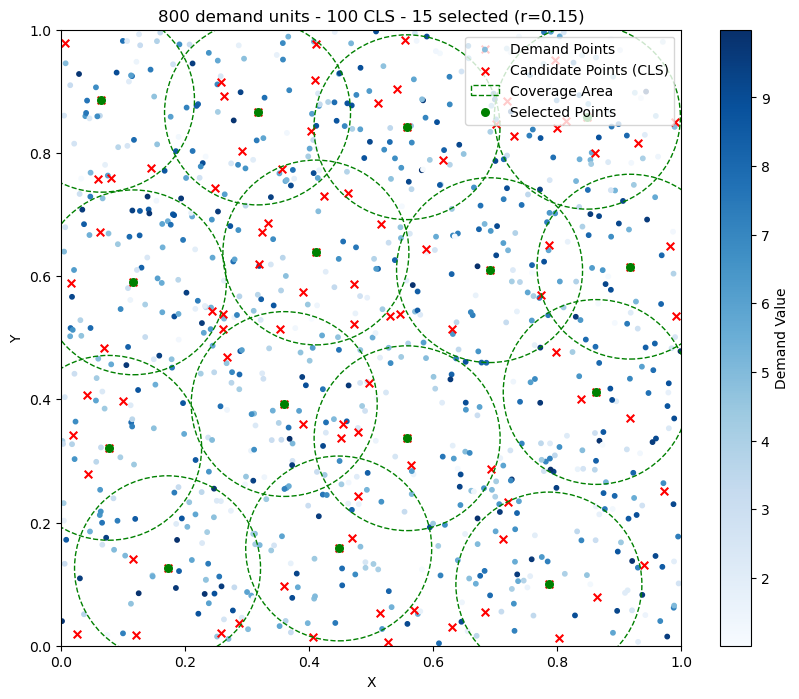

In [77]:
# get the first batch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch = next(iter(dataloader))
batch = move_to(batch, device)

demand_pts = batch['users'].squeeze(0).cpu().numpy()  # (n_users, 2)
demand_vals = batch['demand'].squeeze(0).cpu().numpy() 
cls = batch['facilities'].squeeze(0).cpu().numpy()  # (n_facilities, 2)
r = radius

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, tours[0])
plot_points(demand_pts, demand_vals, cls, tours[0], r)

## GA

Current top solution: [0, 49, 90, 3, 23, 25, 46, 78, 16, 68, 57, 87, 14, 24, 44] f=1189

Final top solution: [66, 57, 95, 4, 84, 88, 19, 3, 5, 49, 72, 60, 32, 48, 14] f=558
Time: 00:00:0.5133
The solution is: [66, 57, 95, 4, 84, 88, 19, 3, 5, 49, 72, 60, 32, 48, 14]
The objective is: 3839
Number of covered demand points: 691
The objective value: [3838.86152574]
[3838.86152574]


C:\Users\yzhon\AppData\Local\Temp\ipykernel_41644\1569368377.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


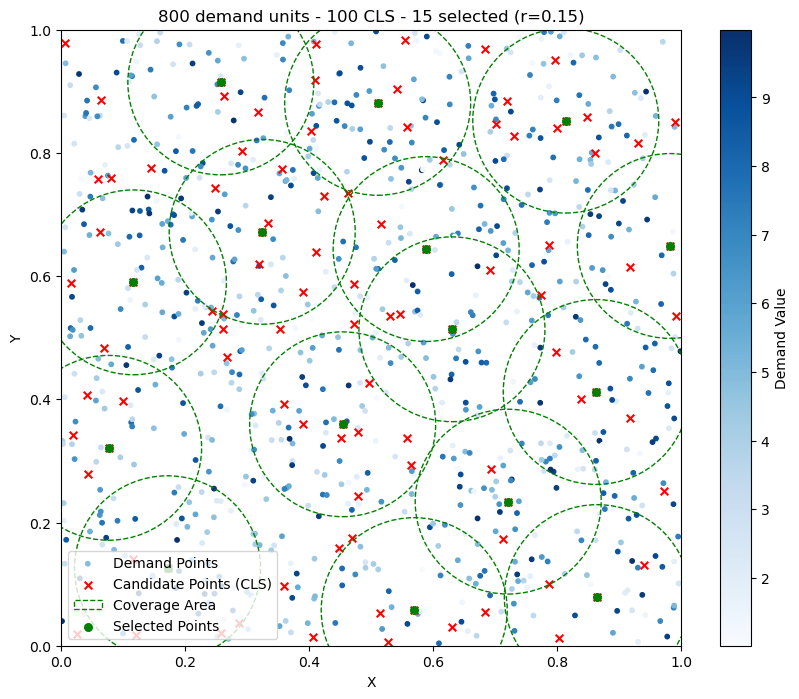

In [78]:
from algorithms.GA import GeneticAlgorithm

dist = np.sum((facilities[:, np.newaxis, :] - users[np.newaxis, :, :]) ** 2, axis=-1) ** 0.5
genetic = GeneticAlgorithm(n_users, n_facilities, n_centers, dist, radius, demand)
genetic.optimize()
obj = np.sum(demand) - genetic.top_chromosome.fitness
centers = genetic.top_chromosome.content

if isinstance(obj, np.ndarray):
    obj = obj.item()  # 将其转换为标量值

print("The solution is: %s" % centers)
print("The objective is: %s" % str(round(obj)))

ga_obj_val = calculate_solution_objective(users, demand, facilities, radius, centers)
print(ga_obj_val)

plot_points(users, demand, facilities, centers, radius)

## Cplex

In [18]:
from docplex.mp.model import Model

def solve_mclp_cplex(demand_pts, demand_vals, facility_candidate_locations, radius, max_num_selection):
    """
    Solves the Maximal Covering Location Problem using CPLEX.
    """
    num_demand_pts = len(demand_pts)
    num_facilities = len(facility_candidate_locations)
    
    # Create a CPLEX model
    mdl = Model(name="MCLP")

    # Decision variables
    x = mdl.binary_var_list(num_facilities, name="x")  # Facility selection variables
    y = mdl.binary_var_list(num_demand_pts, name="y")  # Demand point coverage variables

    # Calculate coverage: which facilities can cover which demand points
    coverage = []
    for i, demand_pt in enumerate(demand_pts):
        facilities_covering_i = []
        for j, facility in enumerate(facility_candidate_locations):
            # Calculate Euclidean distance between demand point and facility
            if np.linalg.norm(np.array(facility) - np.array(demand_pt)) <= radius:
                facilities_covering_i.append(j)
        coverage.append(facilities_covering_i)
    
    # Objective: maximize the total demand covered
    mdl.maximize(mdl.sum(demand_vals[i].item() * y[i] for i in range(num_demand_pts)))

    # Constraints
    # Each demand point i can only be covered if at least one facility that covers it is selected
    for i in range(num_demand_pts):
        mdl.add_constraint(y[i] <= mdl.sum(x[j] for j in coverage[i]))

    # At most max_num_selection facilities can be selected
    mdl.add_constraint(mdl.sum(x[j] for j in range(num_facilities)) <= max_num_selection)

    # Solve the model
    solution = mdl.solve(log_output=True)
    
    if solution:
        print("Objective Value (Total Demand Covered):", solution.objective_value)
        selected_facilities = [j for j in range(num_facilities) if x[j].solution_value > 0.5]
        print("Selected facility indexes:", selected_facilities)
        return selected_facilities
    else:
        print("No solution found.")
        return None

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.01 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 33 rows and 21 columns.
Aggregator did 11 substitutions.
Reduced MIP has 57 rows, 94 columns, and 283 nonzeros.
Reduced MIP has 94 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.38 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 57 rows, 94 columns, and 283 nonzeros.
Reduced MIP has 94 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.19 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 20 threads.
Root relaxation solution time = 0.00 sec. (0.21 ticks)

        Nodes                                         Cuts/
   Node  Left     Objec

C:\Users\yzhon\AppData\Local\Temp\ipykernel_41644\1569368377.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


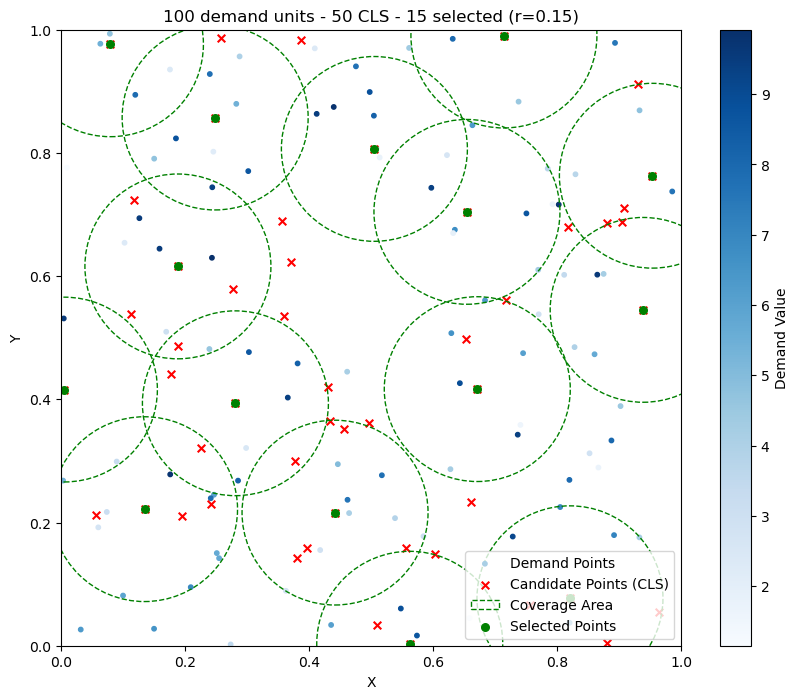

In [19]:
# Solve the problem using the genetic algorithm
max_num_selection = 15
cplex_solution = solve_mclp_cplex(users, demand, facilities, radius, max_num_selection)

obj_val = calculate_solution_objective(users, demand, facilities, radius, cplex_solution)
print(obj_val)

plot_points(users, demand, facilities, cplex_solution, radius)